In [ ]:
########Reading data from Mongo#######
from pyspark.sql import SparkSession
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

# spark mongo connector
spark = SparkSession.builder.master("local[*]").config("spark.mongodb.input.uri","mongodb://localhost:27017/twitter_db.Dummy") .config("spark.mongodb.output.uri","mongodb://locahost:27017/twitter_db.Dummy").config("spark.jars.packages","org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").getOrCreate()
df = spark.read.format("mongo").option("uri","mongodb://localhost:27017/twitter_db.Dummy").load()
df.registerTempTable("Twitter")
#df.count()

In [ ]:
"""
# Cleaning Data
sf_1=df.select("text")
words = sf_1.select(explode(split(df.text, "t_end")).alias("word"))
word=df.select(F.regexp_replace('text', r'http\S+', '').alias("text"))
word=word.select(F.regexp_replace('text', '@\w+', '').alias("text"))
word=word.select(F.regexp_replace('text', '#', '').alias("text"))
word=word.select(F.regexp_replace('text', 'RT', '').alias("text"))
word=word.select(F.regexp_replace('text', ':', '').alias("text"))
word.show(truncate=False)
"""

In [ ]:
##########Feature Selection############

# Selecting required columns
# JSON file we take requried fileds using Spark SQL

sf=df.select(explode(split(df.text, "t_end")).alias("text"),"created_at",col("user.location").alias("Location"),"retweet_count",col("user.followers_count").alias("User_followers"),col("user.favourites_count").alias("favourites_count"),col("user.verified").alias("Verified User"),"lang")
sf=sf.select(F.regexp_replace('text', r'http\S+', '').alias("Text"),"created_at","Location","retweet_count","favourites_count","Verified User","User_followers","lang")
sf=sf.select(F.regexp_replace('Text', '@\w+', '').alias("text"),"created_at","Location","retweet_count","favourites_count","Verified User","User_followers","lang")
sf=sf.select(F.regexp_replace('text', '#', '').alias("text"),"created_at","Location","retweet_count","favourites_count","Verified User","User_followers","lang")
sf=sf.select(F.regexp_replace('text', 'RT', '').alias("text"),"created_at","Location","retweet_count","favourites_count","Verified User","User_followers","lang")
sf=sf.select(F.regexp_replace('text', ':', '').alias("Text"),from_unixtime(unix_timestamp('created_at', 'EEE MMM d HH:mm:ss z yyyy'),format="yyyy-MM-dd").alias('date'),"Location","User_followers","favourites_count","retweet_count","Verified User")
sf=sf.fillna({"Location": "unknown"})
sf=sf.fillna({"retweet_count": 0})
sf=sf.filter((col("lang") == 'en'))

sf.show()
#sf.printSchema()
#sf.show()
#sf.withColumn('newDate',f.date_sub("created_at",10)).show()
#df.show(2)

In [ ]:
#Counting total tweets
#sf.where(col("retweet_count").isin({"0"}))


In [ ]:
############ Writing structured data into MongoDB ###########

sf.write.format("mongo").option("uri","mongodb://localhost:27017/Sample2.Data").mode("append").save()

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pymongo
#import pandas as pd
from pymongo import MongoClient
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
#tweets=pd.read_csv("final.csv",encoding = "ISO-8859-1")
#tweets.head()

In [2]:
connection = pymongo.MongoClient("localhost",27017)
db = connection["twtt"]
collection = db["tweets"]
print("connect to mongoDB")
tweets = pd.DataFrame(collection.find())
#df.to_csv('file1.csv')


connect to mongoDB


In [3]:
#tweets=pd.read_csv("file1.csv",encoding = "ISO-8859-1")

tweets.head()


,_id,Text,date,Location,User_followers,favourites_count,retweet_count,Verified User
0,6005372e28cba40ce364d0bc,Ajith Starrer Valimai Is Expected To Create ...,2021-01-14,Twitter,91,4154,0,False
1,6005372e28cba40ce364d0bd,Powerful edit,2021-01-14,"Aurangabad, India",803,12989,0,False
2,6005372e28cba40ce364d0be,"watch it 👀\nplease like 👍, share and do subscr...",2021-01-14,"Bengaluru, India",25,67,0,False
3,6005372e28cba40ce364d0bf,Cigarette scene Is starrer KGF 2 in trouble? ...,2021-01-14,"Mumbai, India",10124,9125,0,False
4,6005372e28cba40ce364d0c0,Then how can this be possible...\n,2021-01-14,unknown,1404,17010,0,False


In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

from nltk import tokenize

sid = SentimentIntensityAnalyzer()

tweets['sentiment_compound_polarity']=tweets.Text.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.Text.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.Text.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.Text.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
tweets.head()


,_id,Text,date,Location,User_followers,favourites_count,retweet_count,Verified User,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,6005372e28cba40ce364d0bc,Ajith Starrer Valimai Is Expected To Create ...,2021-01-14,Twitter,91,4154,0,False,0.8807,0.603,0.000,0.397,POSITIVE
1,6005372e28cba40ce364d0bd,Powerful edit,2021-01-14,"Aurangabad, India",803,12989,0,False,0.4215,0.263,0.000,0.737,POSITIVE
2,6005372e28cba40ce364d0be,"watch it 👀\nplease like 👍, share and do subscr...",2021-01-14,"Bengaluru, India",25,67,0,False,0.8542,0.556,0.000,0.444,POSITIVE
3,6005372e28cba40ce364d0bf,Cigarette scene Is starrer KGF 2 in trouble? ...,2021-01-14,"Mumbai, India",10124,9125,0,False,-0.4019,0.803,0.197,0.000,NEGATIVE
4,6005372e28cba40ce364d0c0,Then how can this be possible...\n,2021-01-14,unknown,1404,17010,0,False,0.0000,1.000,0.000,0.000,NEUTRAL


In [5]:
#tweets.save

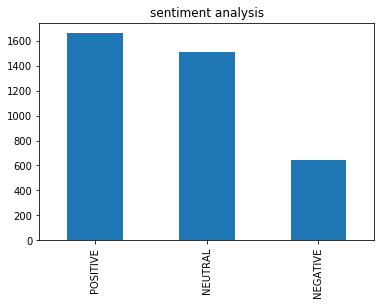

In [6]:
tweets.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

In [7]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('stopwords')

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucifer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
normalizer("Here is text about an airline I like.")

['text', 'airline', 'like']

In [9]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets['normalized_tweet'] = tweets.Text.apply(normalizer)
tweets[['Text','normalized_tweet']].head()

C:\Users\Lucifer\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Text,normalized_tweet
0,Ajith Starrer Valimai Is Expected To Create The Same Impact That Kgf Created All Over India.\n\nVinoth Is Super Confident. T…,"[valimai, expected, create, impact, kgf, created, india, vinoth, super, confident]"
1,Powerful edit,[]
2,"watch it 👀\nplease like 👍, share and do subscribe for more videos YouTube Friends BestFriend KicchaSudeep KGF…","[please, like, share, subscribe, video, youtube, friend, bestfriend, kicchasudeep, kgf]"
3,Cigarette scene Is starrer KGF 2 in trouble? Follow Us on \n\n KGF2 KGF2cigarettescene…,"[starrer, kgf, trouble, follow, u, kgf, kgf, cigarettescene]"
4,Then how can this be possible...\n,[possible]


In [10]:
tweets

,_id,Text,date,Location,User_followers,favourites_count,retweet_count,Verified User,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,normalized_tweet
0,6005372e28cba40ce364d0bc,Ajith Starrer Valimai Is Expected To Create The Same Impact That Kgf Created All Over India.\n\nVinoth Is Super Confident. T…,2021-01-14,Twitter,91,4154,0,False,0.8807,0.603,0.000,0.397,POSITIVE,"[valimai, expected, create, impact, kgf, created, india, vinoth, super, confident]"
1,6005372e28cba40ce364d0bd,Powerful edit,2021-01-14,"Aurangabad, India",803,12989,0,False,0.4215,0.263,0.000,0.737,POSITIVE,[]
2,6005372e28cba40ce364d0be,"watch it 👀\nplease like 👍, share and do subscribe for more videos YouTube Friends BestFriend KicchaSudeep KGF…",2021-01-14,"Bengaluru, India",25,67,0,False,0.8542,0.556,0.000,0.444,POSITIVE,"[please, like, share, subscribe, video, youtube, friend, bestfriend, kicchasudeep, kgf]"
3,6005372e28cba40ce364d0bf,Cigarette scene Is starrer KGF 2 in trouble? Follow Us on \n\n KGF2 KGF2cigarettescene…,2021-01-14,"Mumbai, India",10124,9125,0,False,-0.4019,0.803,0.197,0.000,NEGATIVE,"[starrer, kgf, trouble, follow, u, kgf, kgf, cigarettescene]"
4,6005372e28cba40ce364d0c0,Then how can this be possible...\n,2021-01-14,unknown,1404,17010,0,False,0.0000,1.000,0.000,0.000,NEUTRAL,[possible]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,6005372e28cba40ce364df94,Monday 10Am \nSomething posting Be Ready Guys\n🔥😊😊\nKGFChapter2 KGF \nYash,2021-01-16,unknown,19,4169,0,False,0.3612,0.800,0.000,0.200,POSITIVE,"[something, posting, ready, guy, kgfchapter, kgf, yash]"
3801,6005372e28cba40ce364df95,OMG! 😱🤩 kgf2 Star Yash 🤩 and Baahubali in ONE frame!!! 🔥🔥\n\nthevocalnews\n\nKGF star Yash joins Baahubali fame…,2021-01-16,unknown,3,1,0,False,0.0000,1.000,0.000,0.000,NEUTRAL,"[star, yash, baahubali, one, frame, thevocalnews, kgf, star, yash, join, baahubali, fame]"
3802,6005372e28cba40ce364df96,"""When Pan Indian films like Master, KGF, Baahubali comes all state distributors will cooperate"" \n\n""Even though this i…",2021-01-16,unknown,117,30222,0,False,0.3612,0.872,0.000,0.128,POSITIVE,"[indian, film, like, master, kgf, baahubali, come, state, distributor, cooperate, even, though]"
3803,6005372e28cba40ce364df97,BAHUBALI 2 trailer 11 cr views in 3 YEARS RRR 3.8 cr in 3 MONTHS and KGF 2 14 cr in 3 DAYS.. OUCHH! This is a STOMACH PUNCH…,2021-01-16,unknown,0,11,0,False,0.0000,1.000,0.000,0.000,NEUTRAL,"[cr, view, year, rrr, cr, month, kgf, cr, day, ouchh, stomach, punch]"


In [11]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
0,"[valimai expected, expected create, create impact, impact kgf, kgf created, created india, india vinoth, vinoth super, super confident, valimai expected create, expected create impact, create impact kgf, impact kgf created, kgf created india, created india vinoth, india vinoth super, vinoth super confident]"
1,[]
2,"[please like, like share, share subscribe, subscribe video, video youtube, youtube friend, friend bestfriend, bestfriend kicchasudeep, kicchasudeep kgf, please like share, like share subscribe, share subscribe video, subscribe video youtube, video youtube friend, youtube friend bestfriend, friend bestfriend kicchasudeep, bestfriend kicchasudeep kgf]"
3,"[starrer kgf, kgf trouble, trouble follow, follow u, u kgf, kgf kgf, kgf cigarettescene, starrer kgf trouble, kgf trouble follow, trouble follow u, follow u kgf, u kgf kgf, kgf kgf cigarettescene]"
4,[]


In [12]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [14]:
import numpy as np
tweets[(tweets.sentiment_type == 'NEGATIVE')][['grams']].apply(count_words)['grams'].most_common(20)

[('rocking star', 280),
 ('star yash', 278),
 ('kgf rocking', 277),
 ('yash rebel', 277),
 ('rebel star', 277),
 ('star prabhas', 277),
 ('prabhas movie', 277),
 ('movie launch', 277),
 ('launch salaar', 277),
 ('salaar salaar', 277),
 ('salaar prabhas', 277),
 ('kgf rocking star', 277),
 ('rocking star yash', 277),
 ('star yash rebel', 277),
 ('yash rebel star', 277),
 ('rebel star prabhas', 277),
 ('star prabhas movie', 277),
 ('prabhas movie launch', 277),
 ('movie launch salaar', 277),
 ('launch salaar salaar', 277)]

In [16]:
tweets[(tweets.sentiment_type == 'POSITIVE')][['grams']].apply(count_words)['grams'].most_common(20)

[('prabhas salaarlaunch', 492),
 ('yash arrives', 470),
 ('fame yash', 455),
 ('arrives hyderabad', 454),
 ('hyderabad attend', 454),
 ('attend prabhas', 454),
 ('salaarlaunch event', 454),
 ('event salaar', 454),
 ('salaar salaarsagabegins', 454),
 ('fame yash arrives', 454),
 ('yash arrives hyderabad', 454),
 ('arrives hyderabad attend', 454),
 ('hyderabad attend prabhas', 454),
 ('attend prabhas salaarlaunch', 454),
 ('prabhas salaarlaunch event', 454),
 ('salaarlaunch event salaar', 454),
 ('event salaar salaarsagabegins', 454),
 ('salaarsagabegins salaarlaun', 452),
 ('salaar salaarsagabegins salaarlaun', 452),
 ('biggest franchise', 234)]

In [17]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [18]:
vectorized_data = count_vectorizer.fit_transform(tweets.Text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [19]:
def sentiment2target(sentiment):
    return {
        'NEGATIVE': 0,
        'NEUTRAL': 1,
        'POSITIVE' : 2
    }[sentiment]
targets = tweets.sentiment_type.apply(sentiment2target)

In [20]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

In [21]:
"""s
from sklearn import navie bays
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

"""

#clf.score(data_test, targets_test)

In [22]:
from sklearn imsport svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

In [24]:
clf.score(data_test, targets_test)

0.9572930354796321

In [25]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[0.00885728, 0.95757225, 0.03357047],
       [0.0051767 , 0.8884954 , 0.10632789],
       [0.0069424 , 0.84278514, 0.15027246],
       [0.02301093, 0.93901473, 0.03797434],
       [0.00534217, 0.79118646, 0.20347137],
       [0.00257463, 0.93573774, 0.06168763],
       [0.01065107, 0.97198998, 0.01735895]])

In [26]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [27]:
def marginal(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [marginal(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].Text, margin[0:10]))

['  You gave your reaction to KGF 2 TEASER.\nPublic gave reaction to your reaction.😆😆😆😆😆😆\nDo you like it… ',
 '     Before KGF there is a ultra film like\nUshh\nUpendra \nA\nOm',
 '  Her Juicy Body and Sweet Pu$$y 💥 entrance to the heaven 💥💥💥\n\n. It must be so delicious, lickerish and tempting. 👅👅✊💦💦😍 ht…',
 '  Previous Old Teaser Records All Now Under The Name Of RockyBhai \n\nNot In KA\nNot in South India\nNot In Whole India\nRocky…',
 '   Credits is always given to  for sure\nBut framing as Only Ka… ',
 ' You need to step out of your comfort zone, stop being a KGF AndhBhakt he just expressed his opinion.',
 ' Those Are Real Time Views... We Are Posting Only Updated Views...\n\nFor Eg  KGF Chapter 2 Real Tim… ',
 ' Break record of kgf 2 poster 31 million tweets.india s biggest trend for poster.',
 '  Best screenplay movie anthe idhe. \nIlanti typical new kind screenplay nenu malli KGF daka chudaledu 🙏\n\n18YearsForClassicOk…',
 "KGF 2 Teaser to be Deleted From YouTube? Activists Sl

In [28]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))

[array([4.99184100e-01, 5.02752995e-08, 5.00815850e-01]),
 array([0.00444054, 0.48795138, 0.50760809]),
 array([0.02039394, 0.50072363, 0.47888243]),
 array([4.88728283e-01, 4.48288341e-05, 5.11226888e-01]),
 array([0.10390941, 0.46564994, 0.43044065]),
 array([0.10078174, 0.43193629, 0.46728196]),
 array([0.34463415, 0.39699031, 0.25837554]),
 array([0.01002509, 0.52132132, 0.46865359]),
 array([0.00847555, 0.52601983, 0.46550462]),
 array([5.50175593e-01, 3.00757181e-05, 4.49794331e-01])]

In [29]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].Text, margin[-10:]))

['  POWERFUL PEOPLE MAKE POWERFUL MOVIES\nSalaar\nKgf\nPrabhas   \nSalaarLaunch Tom…',
 '  POWERFUL PEOPLE MAKE POWERFUL MOVIES\nSalaar\nKgf\nPrabhas   \nSalaarLaunch Tom…',
 '  POWERFUL PEOPLE MAKE POWERFUL MOVIES\nSalaar\nKgf\nPrabhas   \nSalaarLaunch Tom…',
 '  POWERFUL PEOPLE MAKE POWERFUL MOVIES\nSalaar\nKgf\nPrabhas   \nSalaarLaunch Tom…',
 'KGF Chapter 2 Teaser | Yash | KGFchapter 2 Teaser 150 million views\n',
 'whole world enjoying KGF chapter 2 teaser\n\nBut this shit 💩finding physics in teaser  lowda rathee \n\nNe… ',
 '  whole world enjoying KGF chapter 2 teaser\n\nBut this shit 💩finding physics in teaser  lowda rathee \n\nNever m…',
 '  whole world enjoying KGF chapter 2 teaser\n\nBut this shit 💩finding physics in teaser  lowda rathee \n\nNever m…',
 '  whole world enjoying KGF chapter 2 teaser\n\nBut this shit 💩finding physics in teaser  lowda rathee \n\nNever m…',
 '  whole world enjoying KGF chapter 2 teaser\n\nBut this shit 💩finding physics in teaser  lowda rathee \n\n

In [30]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))

[array([0.00131593, 0.00130455, 0.99737952]),
 array([0.00131593, 0.00130455, 0.99737952]),
 array([0.00131593, 0.00130455, 0.99737952]),
 array([0.00131593, 0.00130455, 0.99737952]),
 array([9.98314238e-01, 2.60318672e-05, 1.65973043e-03]),
 array([9.98382511e-01, 2.77857649e-04, 1.33963144e-03]),
 array([9.98591482e-01, 3.65009267e-04, 1.04350844e-03]),
 array([9.98591482e-01, 3.65009267e-04, 1.04350844e-03]),
 array([9.98591482e-01, 3.65009267e-04, 1.04350844e-03]),
 array([9.98591482e-01, 3.65009267e-04, 1.04350844e-03])]

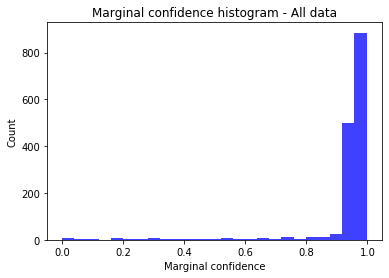

In [31]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

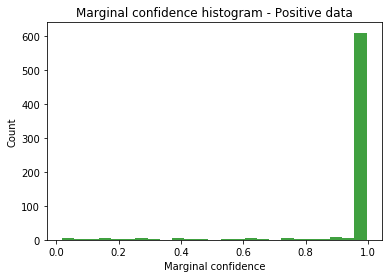

In [32]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

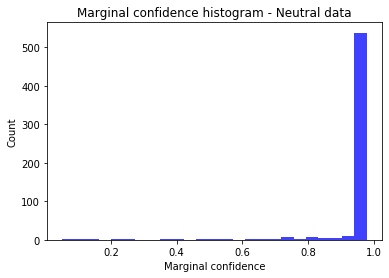

In [33]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

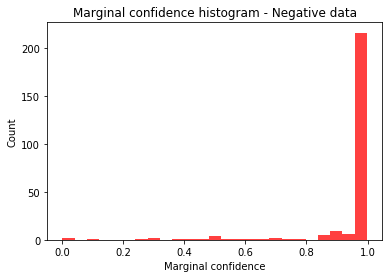

In [34]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : marginal(p), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()